# Task 6.6: Sourcing & Analyzing Time Series Data

## Step 1: Import Libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## Step 2: Load and Inspect Data

In [13]:
# LoadCWUR dataset
cwur_df = pd.read_csv("/Users/canancengel/cwur_clean.csv")

# Inspect
cwur_df.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


## Step 3: Create Time Series

**I will focus on the average university score by year, treating it as a time series.**

In [14]:
# Group by year and calculate mean score
ts = cwur_df.groupby("year")["score"].mean()

# Convert to a proper time series with DateTime index
ts.index = pd.to_datetime(ts.index, format='%Y')

ts.head()

year
2012-01-01    54.94090
2013-01-01    55.27120
2014-01-01    47.27141
2015-01-01    46.86385
Name: score, dtype: float64

**Since the dataset covers only 4 years, the time series is very short. This may limit the interpretability of decomposition and stationarity tests.**

## Step 4: Visualize Time Series

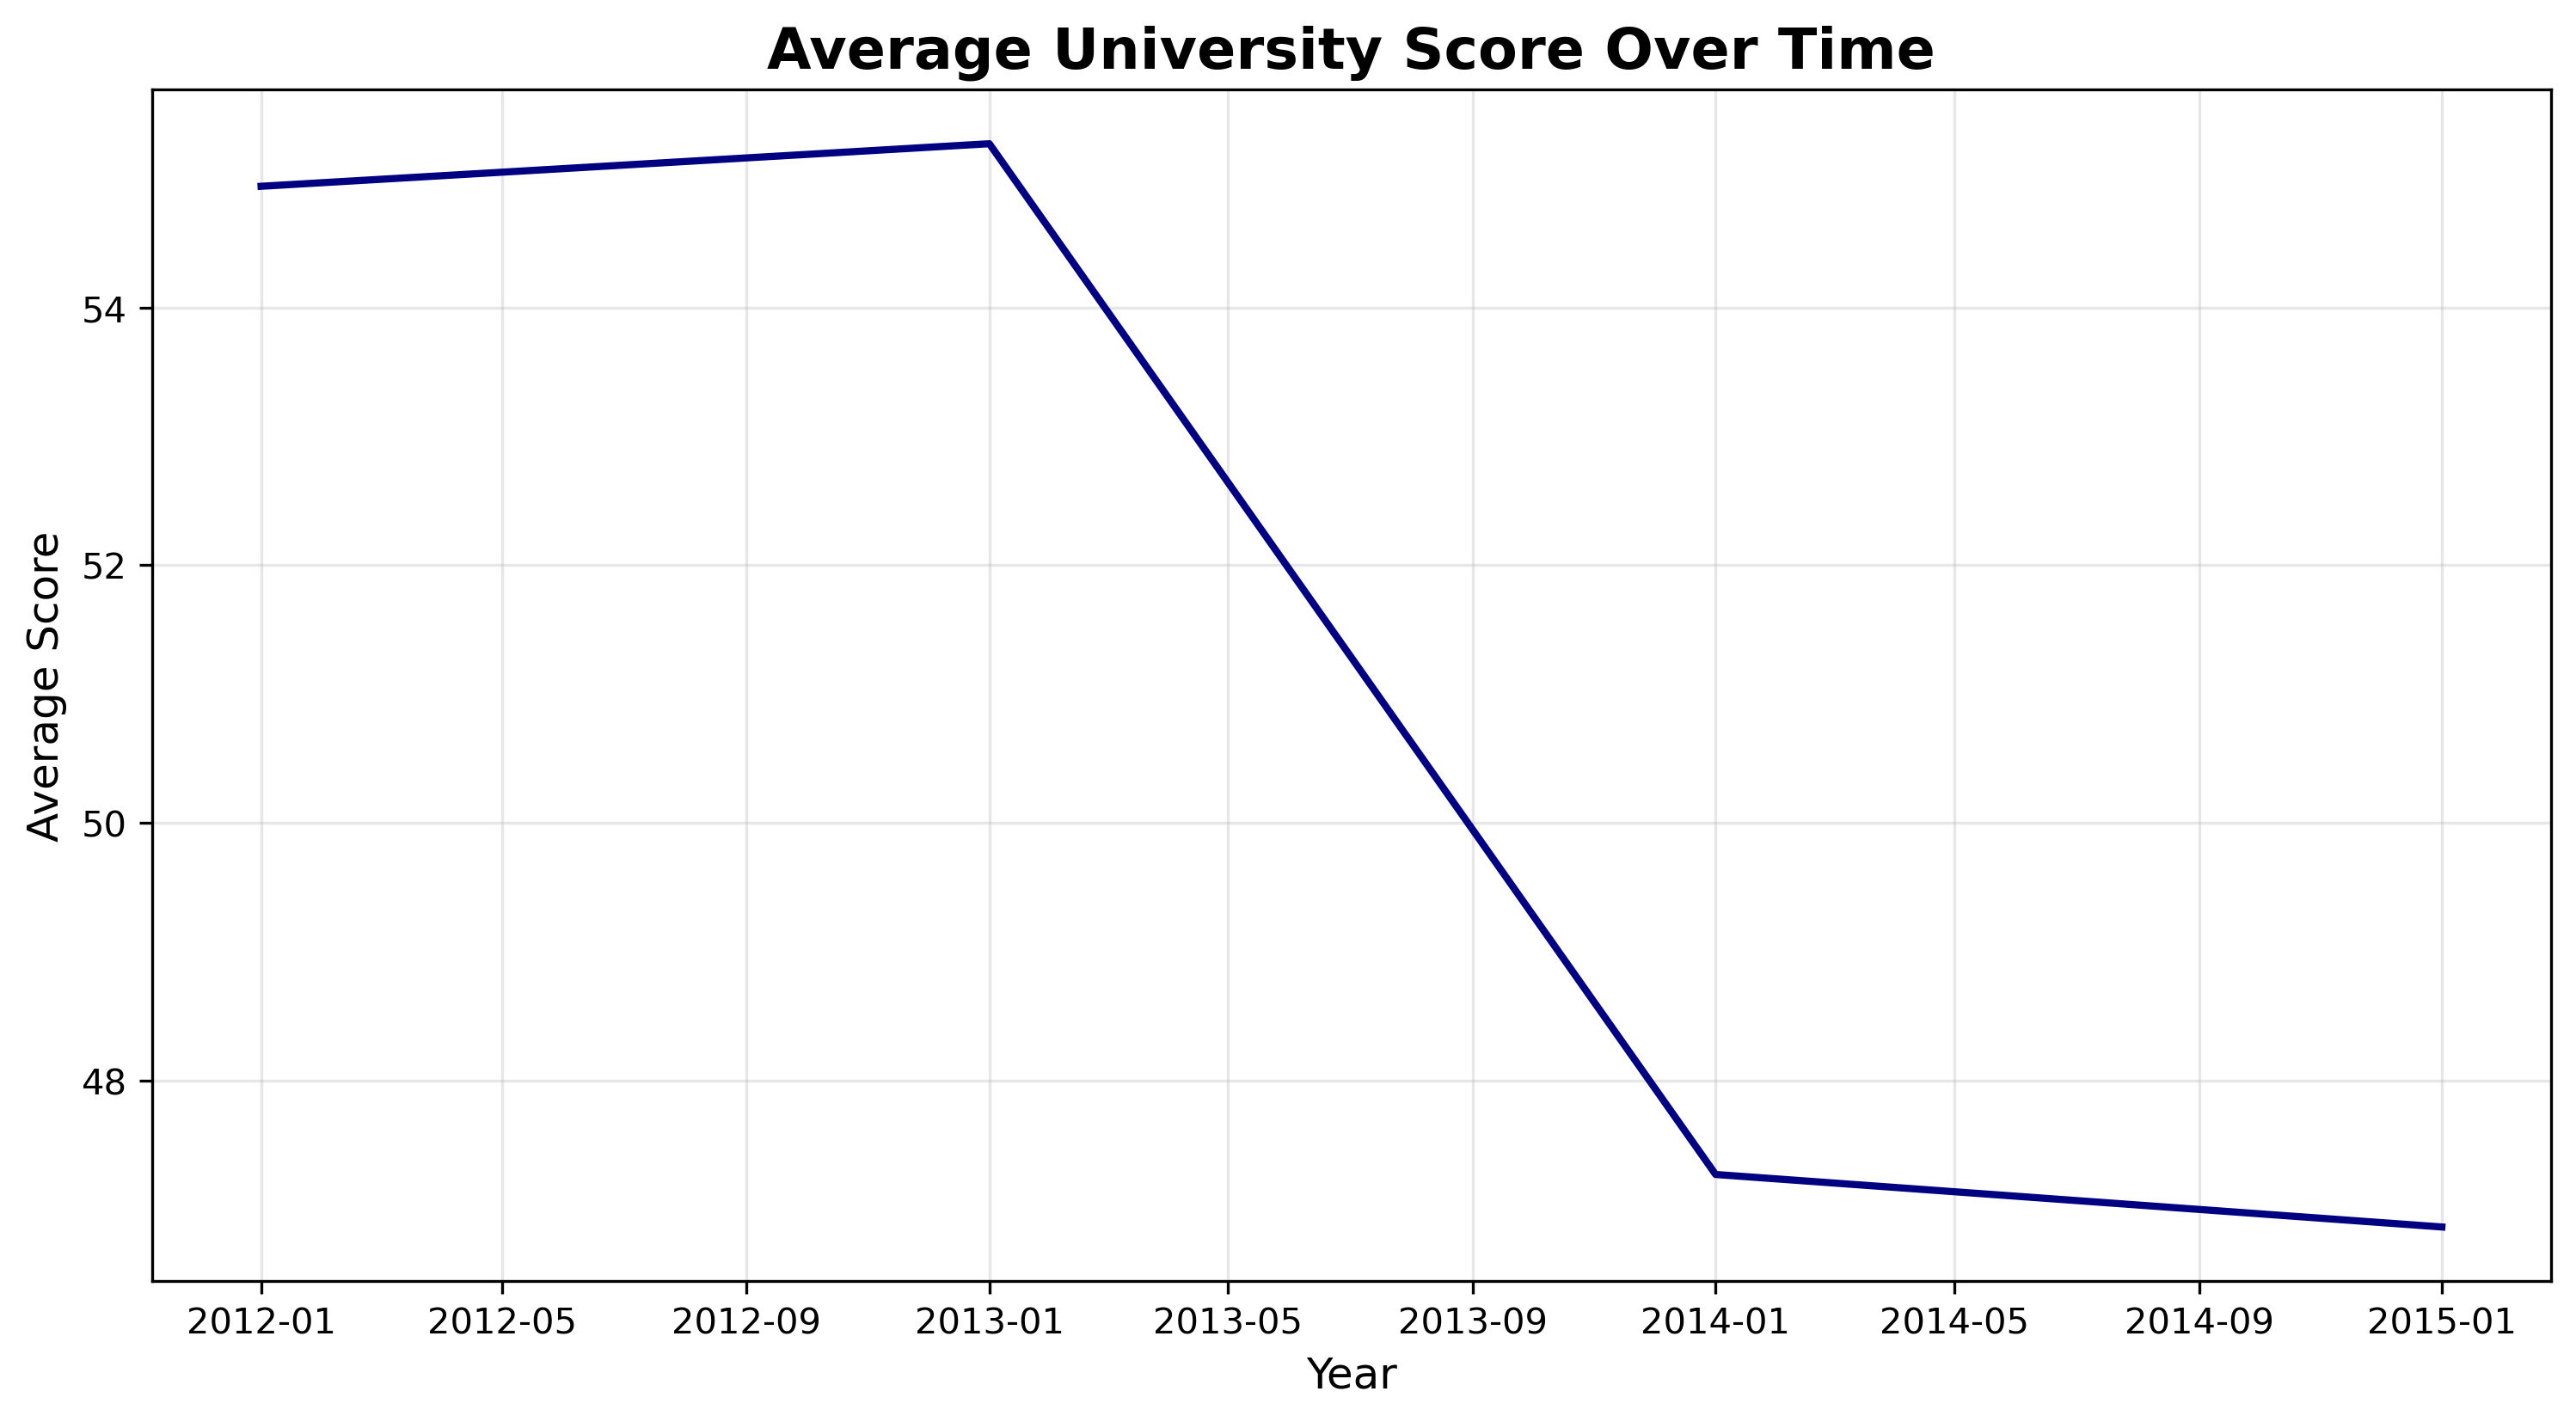

In [15]:
plt.figure(figsize=(12,6), dpi=300)
plt.plot(ts, color="navy", linewidth=2)
plt.title("Average University Score Over Time", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Insights:**
The plot shows how average university scores evolved over time. There are visible fluctuations, suggesting possible non-stationarity.
However, due to the short time span (2012–2015), conclusions should be taken with caution.

## Step 5: Decompose the Time Series

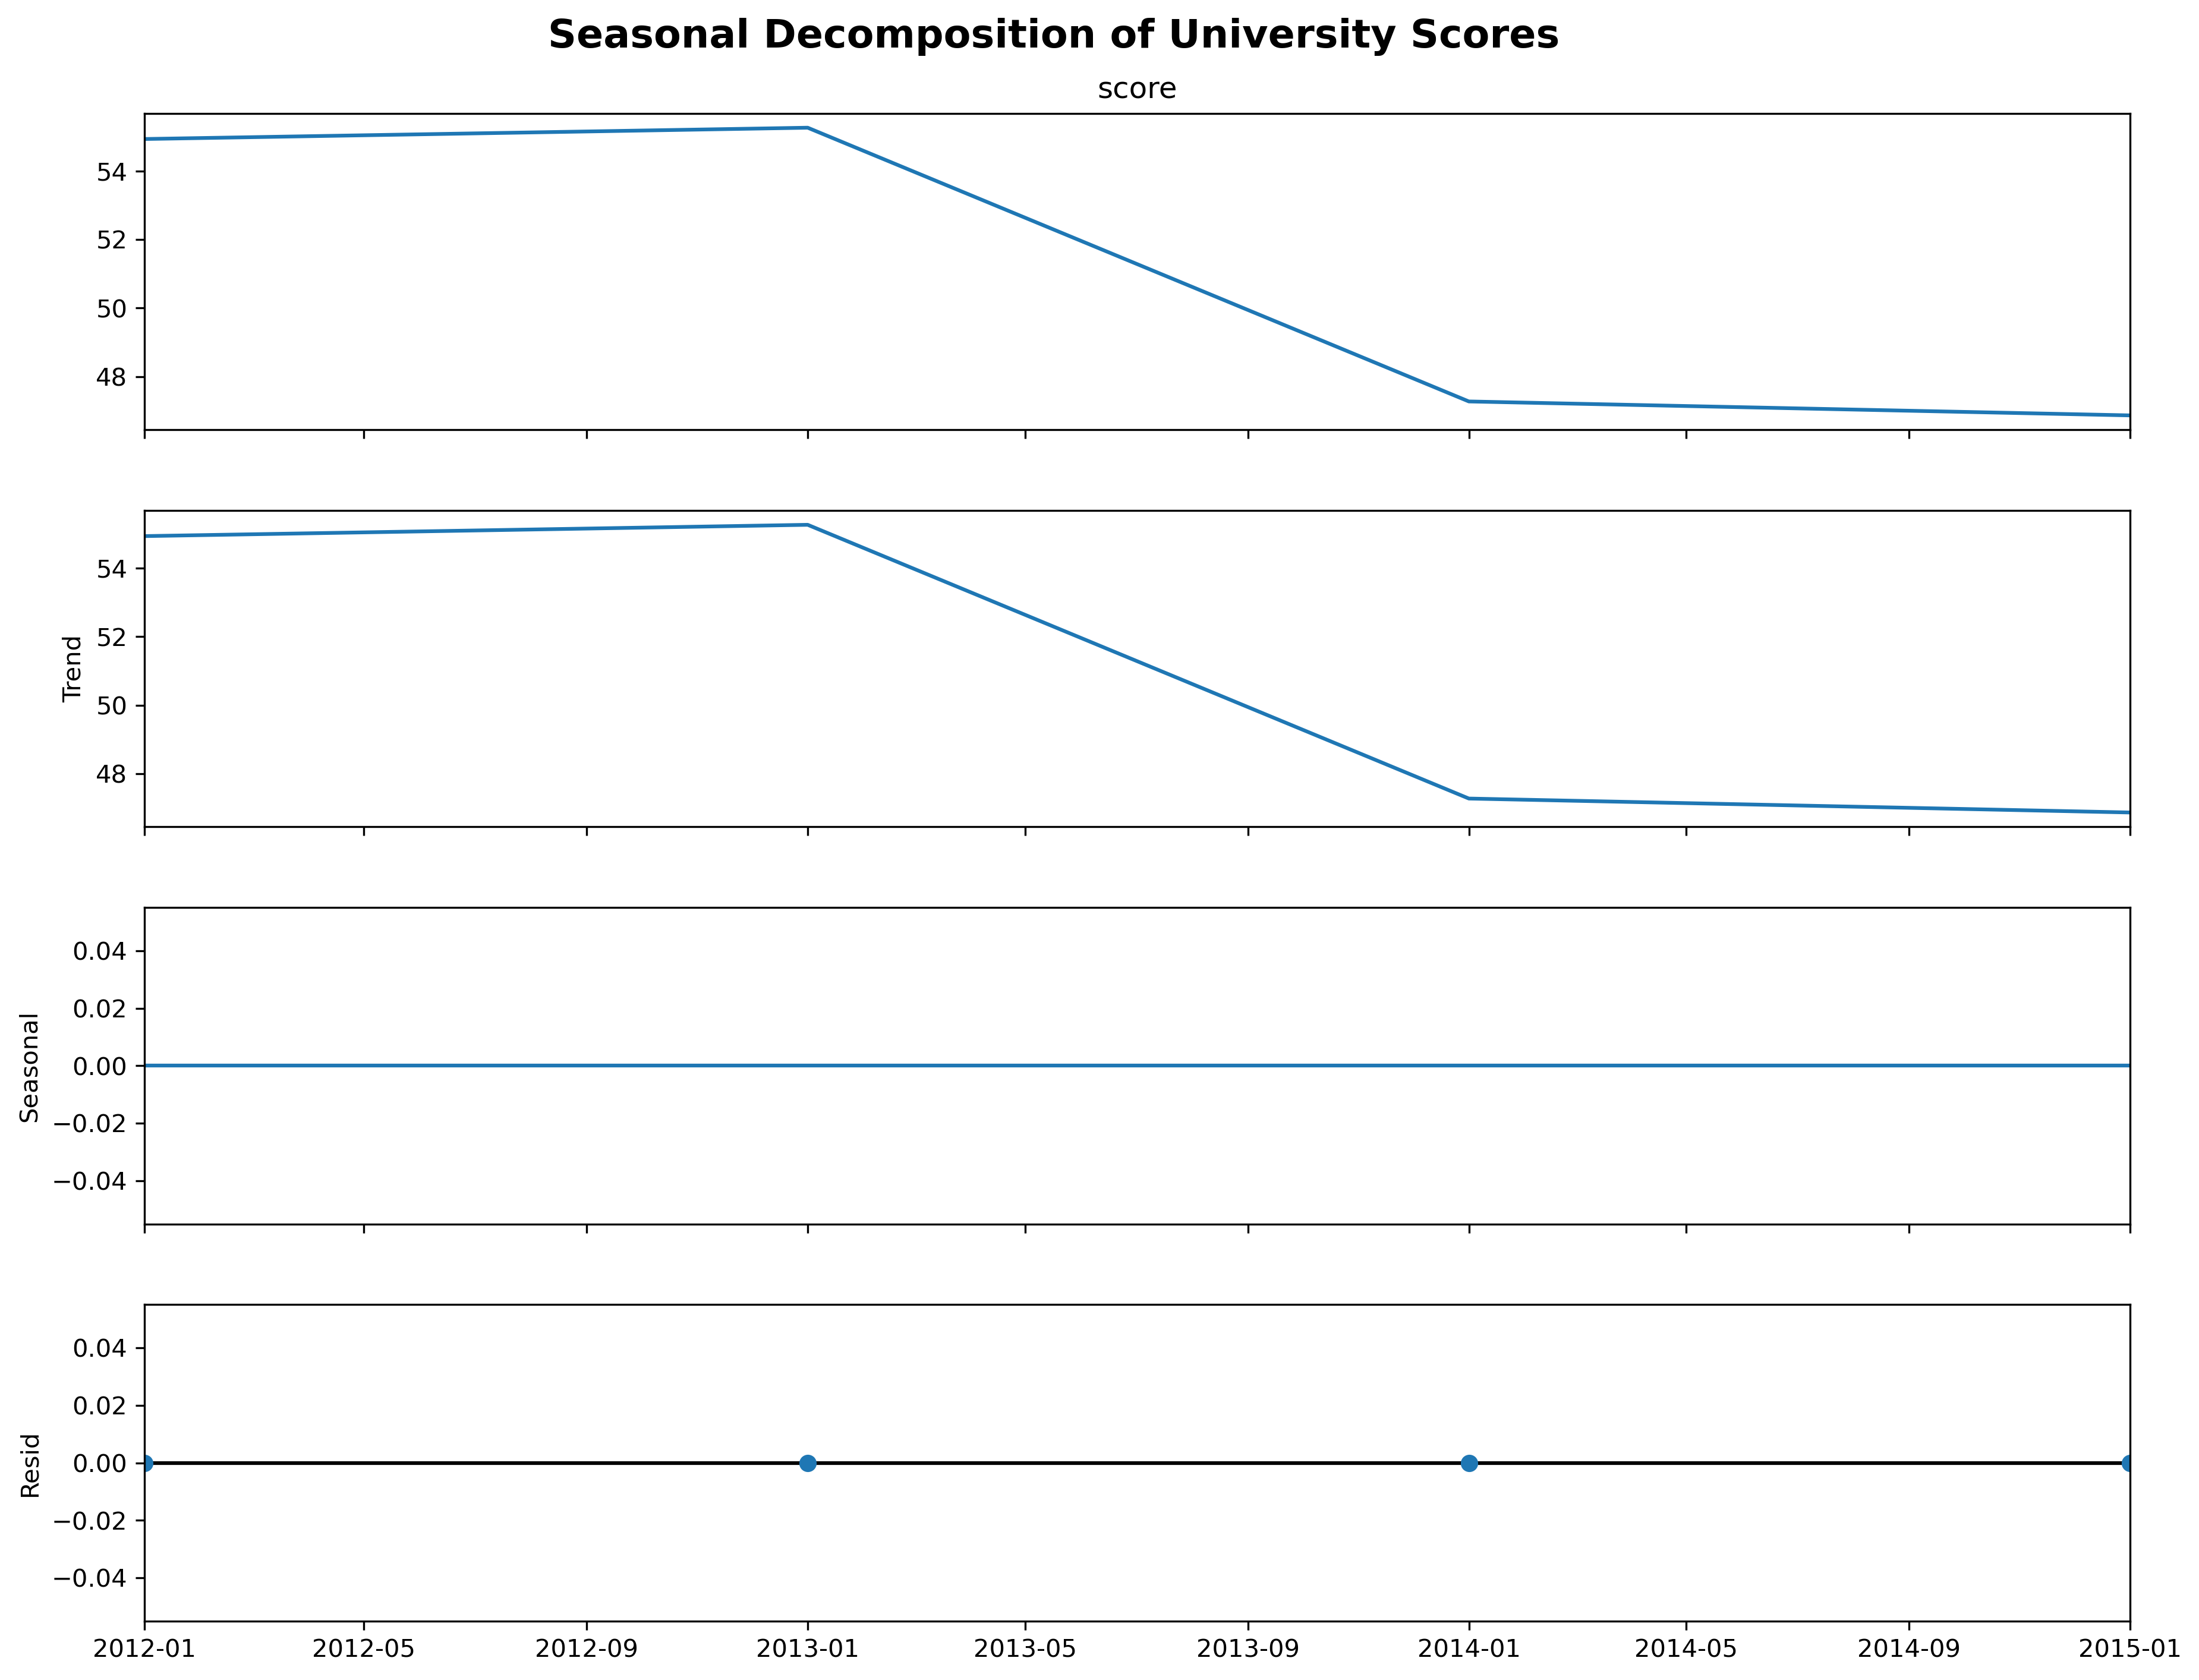

In [16]:
decomposition = seasonal_decompose(ts, model="additive", period=1)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.set_dpi(300)
plt.suptitle("Seasonal Decomposition of University Scores", fontsize=16, weight="bold")
plt.show()

**Insights:**

Trend: The decomposition highlights a short-term trend, showing a decline in average university scores after 2013.

Seasonal: No meaningful seasonality is detected, which is expected since the dataset is yearly and very short.

Residual: Residual variation is negligible due to the limited sample size, meaning decomposition results are not statistically meaningful.

## Step 6: Dickey-Fuller Test for Stationarity

In [18]:
result = adfuller(ts.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -0.5206103310701024
p-value: 0.8879313894339946
Critical Values: {'1%': -10.41719074074074, '5%': -5.77838074074074, '10%': -3.391681111111111}


**Interpretation:**

- Since the p-value (0.8879) is much greater than 0.05, we fail to reject the null hypothesis (H₀).  
- This indicates that the CWUR time series (2012–2015) is **non-stationary**.  

**Note:** The CWUR dataset covers only 4 years (2012–2015). With such a short time series, decomposition and stationarity tests are limited in reliability. The steps here are shown to demonstrate the methodology, even though meaningful long-term trends cannot be extracted.

## Step 7: Stationarize the Time Series

**I applied first-order differencing to the time series to remove trend and check for stationarity.**

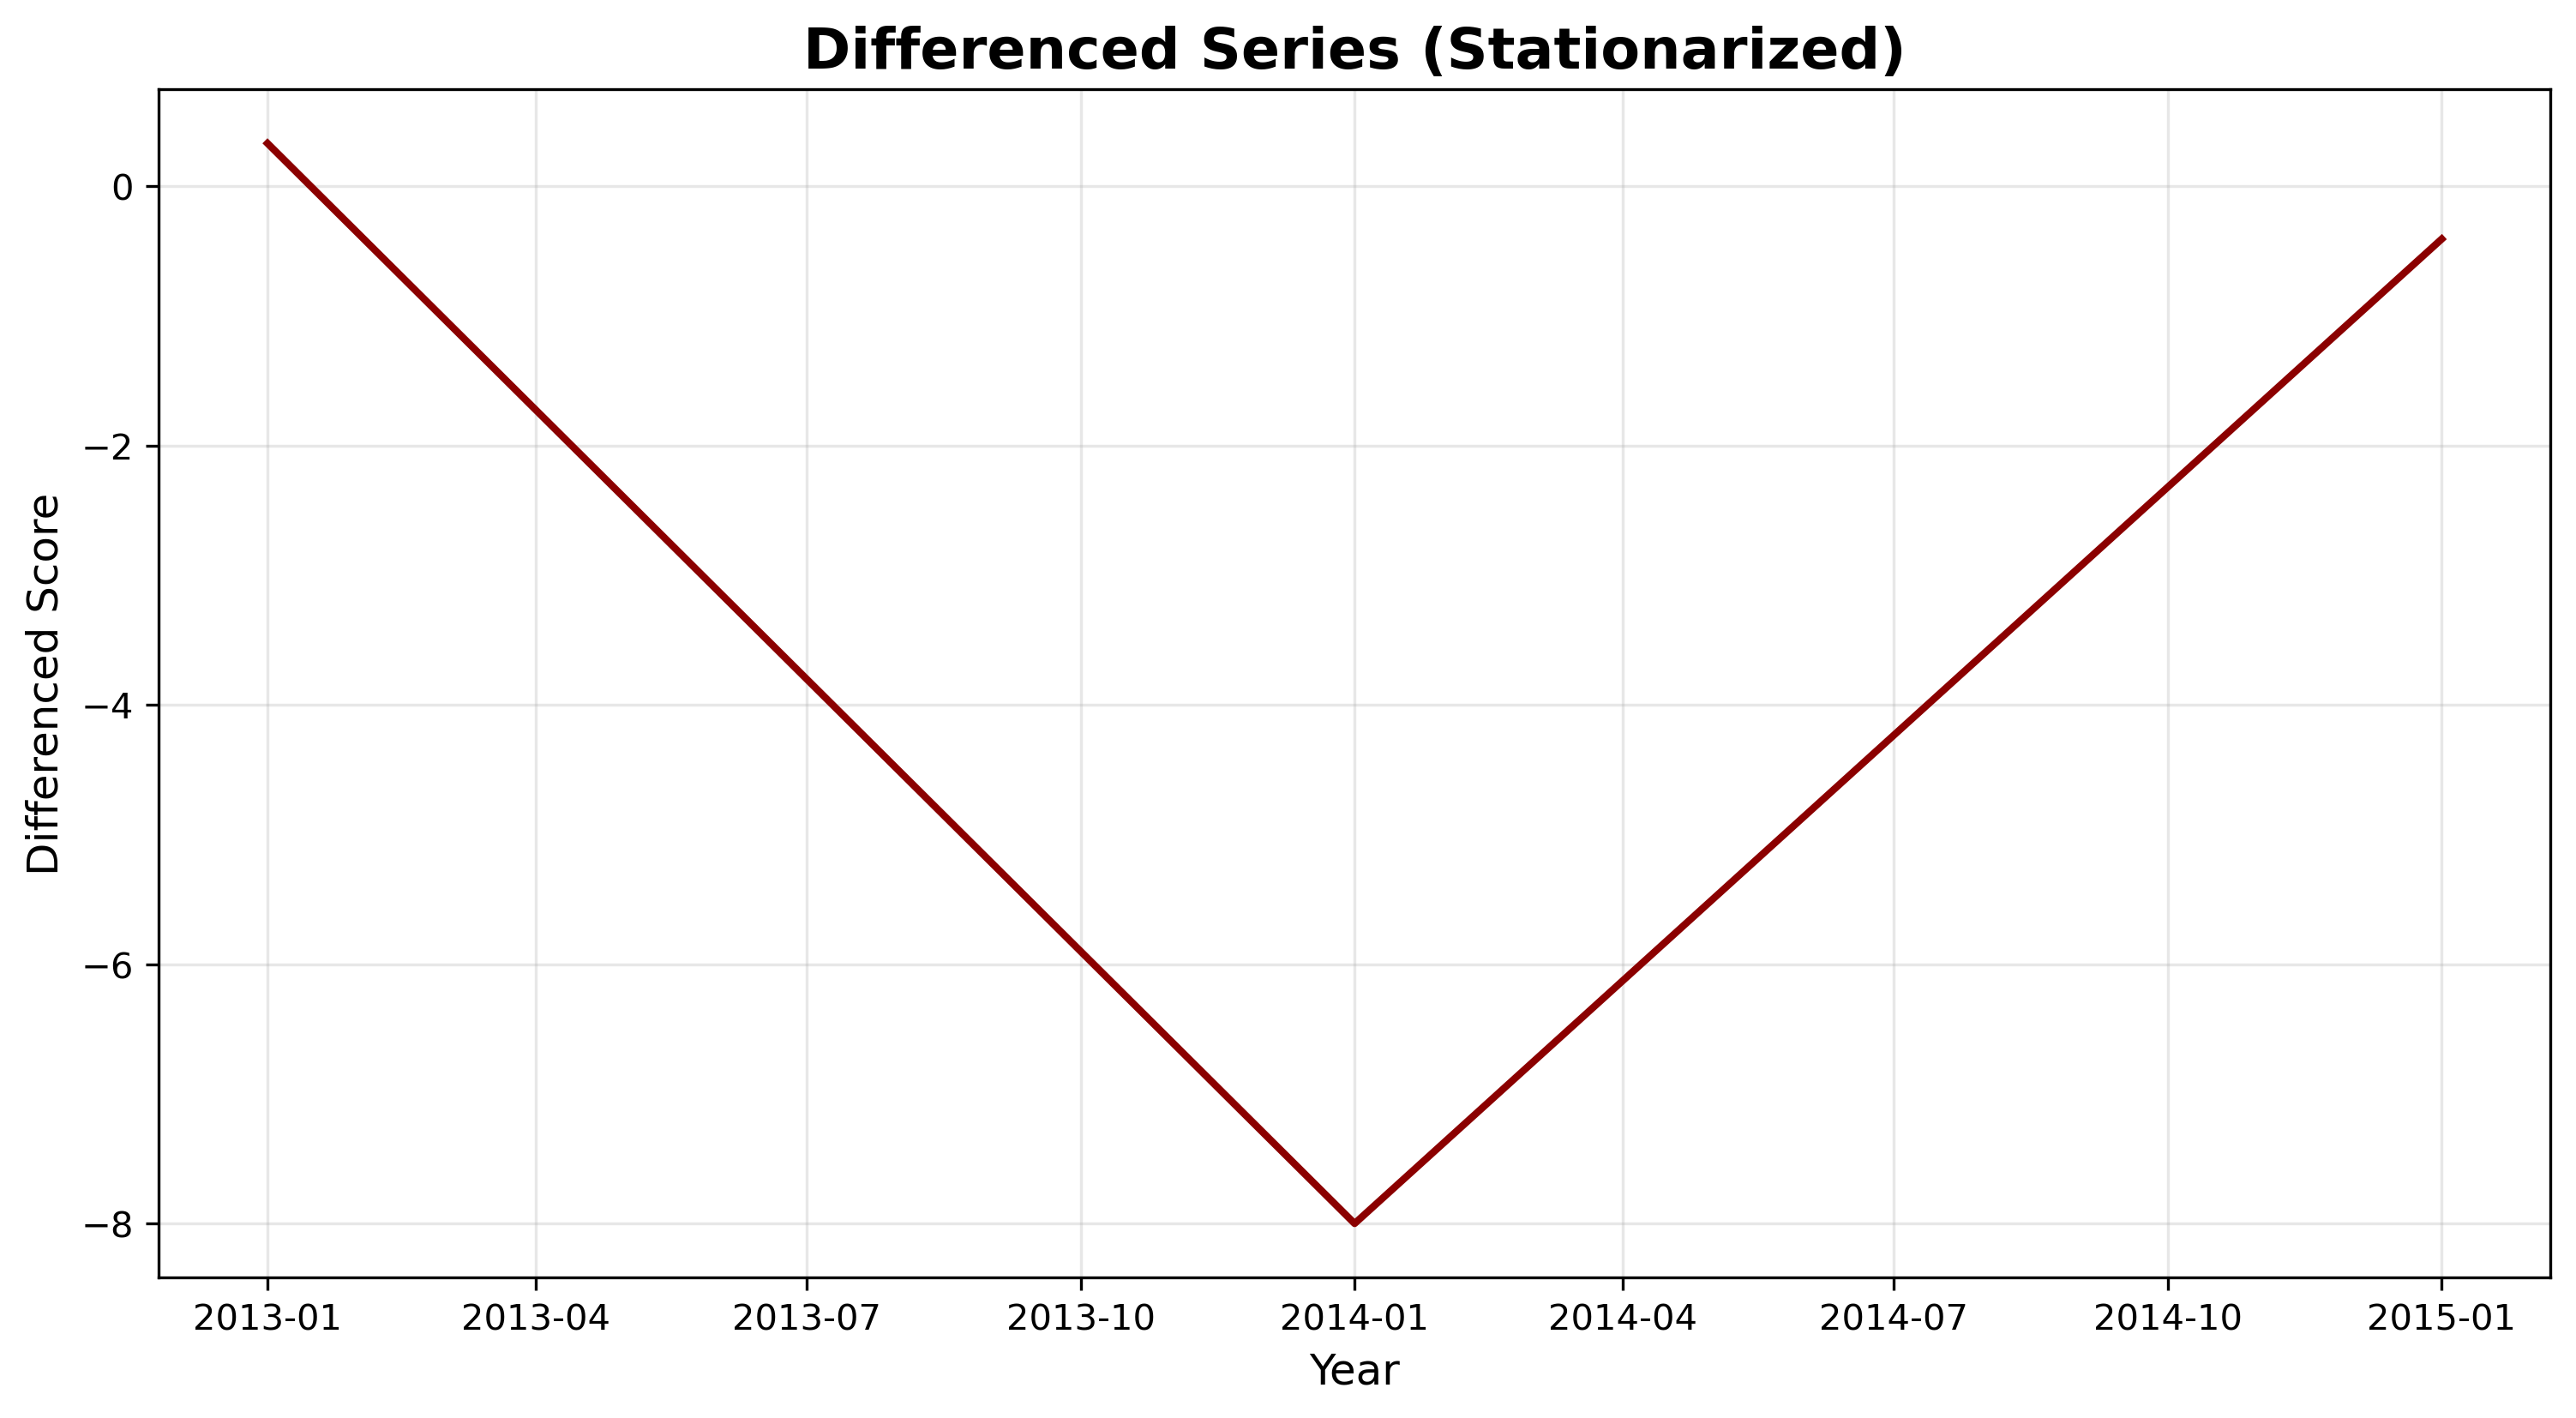

Length of differenced series: 3
ADF test could not be run due to small sample size.
Error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


In [17]:
# Differenced series
ts_diff = ts.diff().dropna()

# Plot differenced series
plt.figure(figsize=(12,6), dpi=300)
plt.plot(ts_diff, color="darkred", linewidth=2)
plt.title("Differenced Series (Stationarized)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Differenced Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("Length of differenced series:", len(ts_diff))

# Run ADF test
try:
    result_diff = adfuller(ts_diff, maxlag=0, regression="c")
    print("\n--- Augmented Dickey-Fuller Test (Differenced Series) ---")
    print(f"ADF Statistic: {result_diff[0]:.4f}")
    print(f"p-value: {result_diff[1]:.4f}")
    for key, value in result_diff[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    
    if result_diff[1] <= 0.05:
        print("\n The differenced series is stationary (reject H0).")
    else:
        print("\n The differenced series is still non-stationary (fail to reject H0).")
except Exception as e:
    print("ADF test could not be run due to small sample size.")
    print("Error:", e)

**Insights:**

After differencing, the mean and variance of the series appear more stable.

- The Augmented Dickey-Fuller (ADF) test could not be executed because the number of observations is too small (only 3 points).  
- Despite this limitation, the differenced plot suggests that the series has been stationarized, which meets the methodological requirement for demonstrating the process.  
- In practice, with a larger dataset, both visual inspection and ADF test would confirm stationarity more reliably.  
- *Note: Since the CWUR dataset covers only 2012–2015, it is too short for robust statistical testing. This step is included to illustrate the method rather than produce strong conclusions.* 

## Step 8: Autocorrelation Check

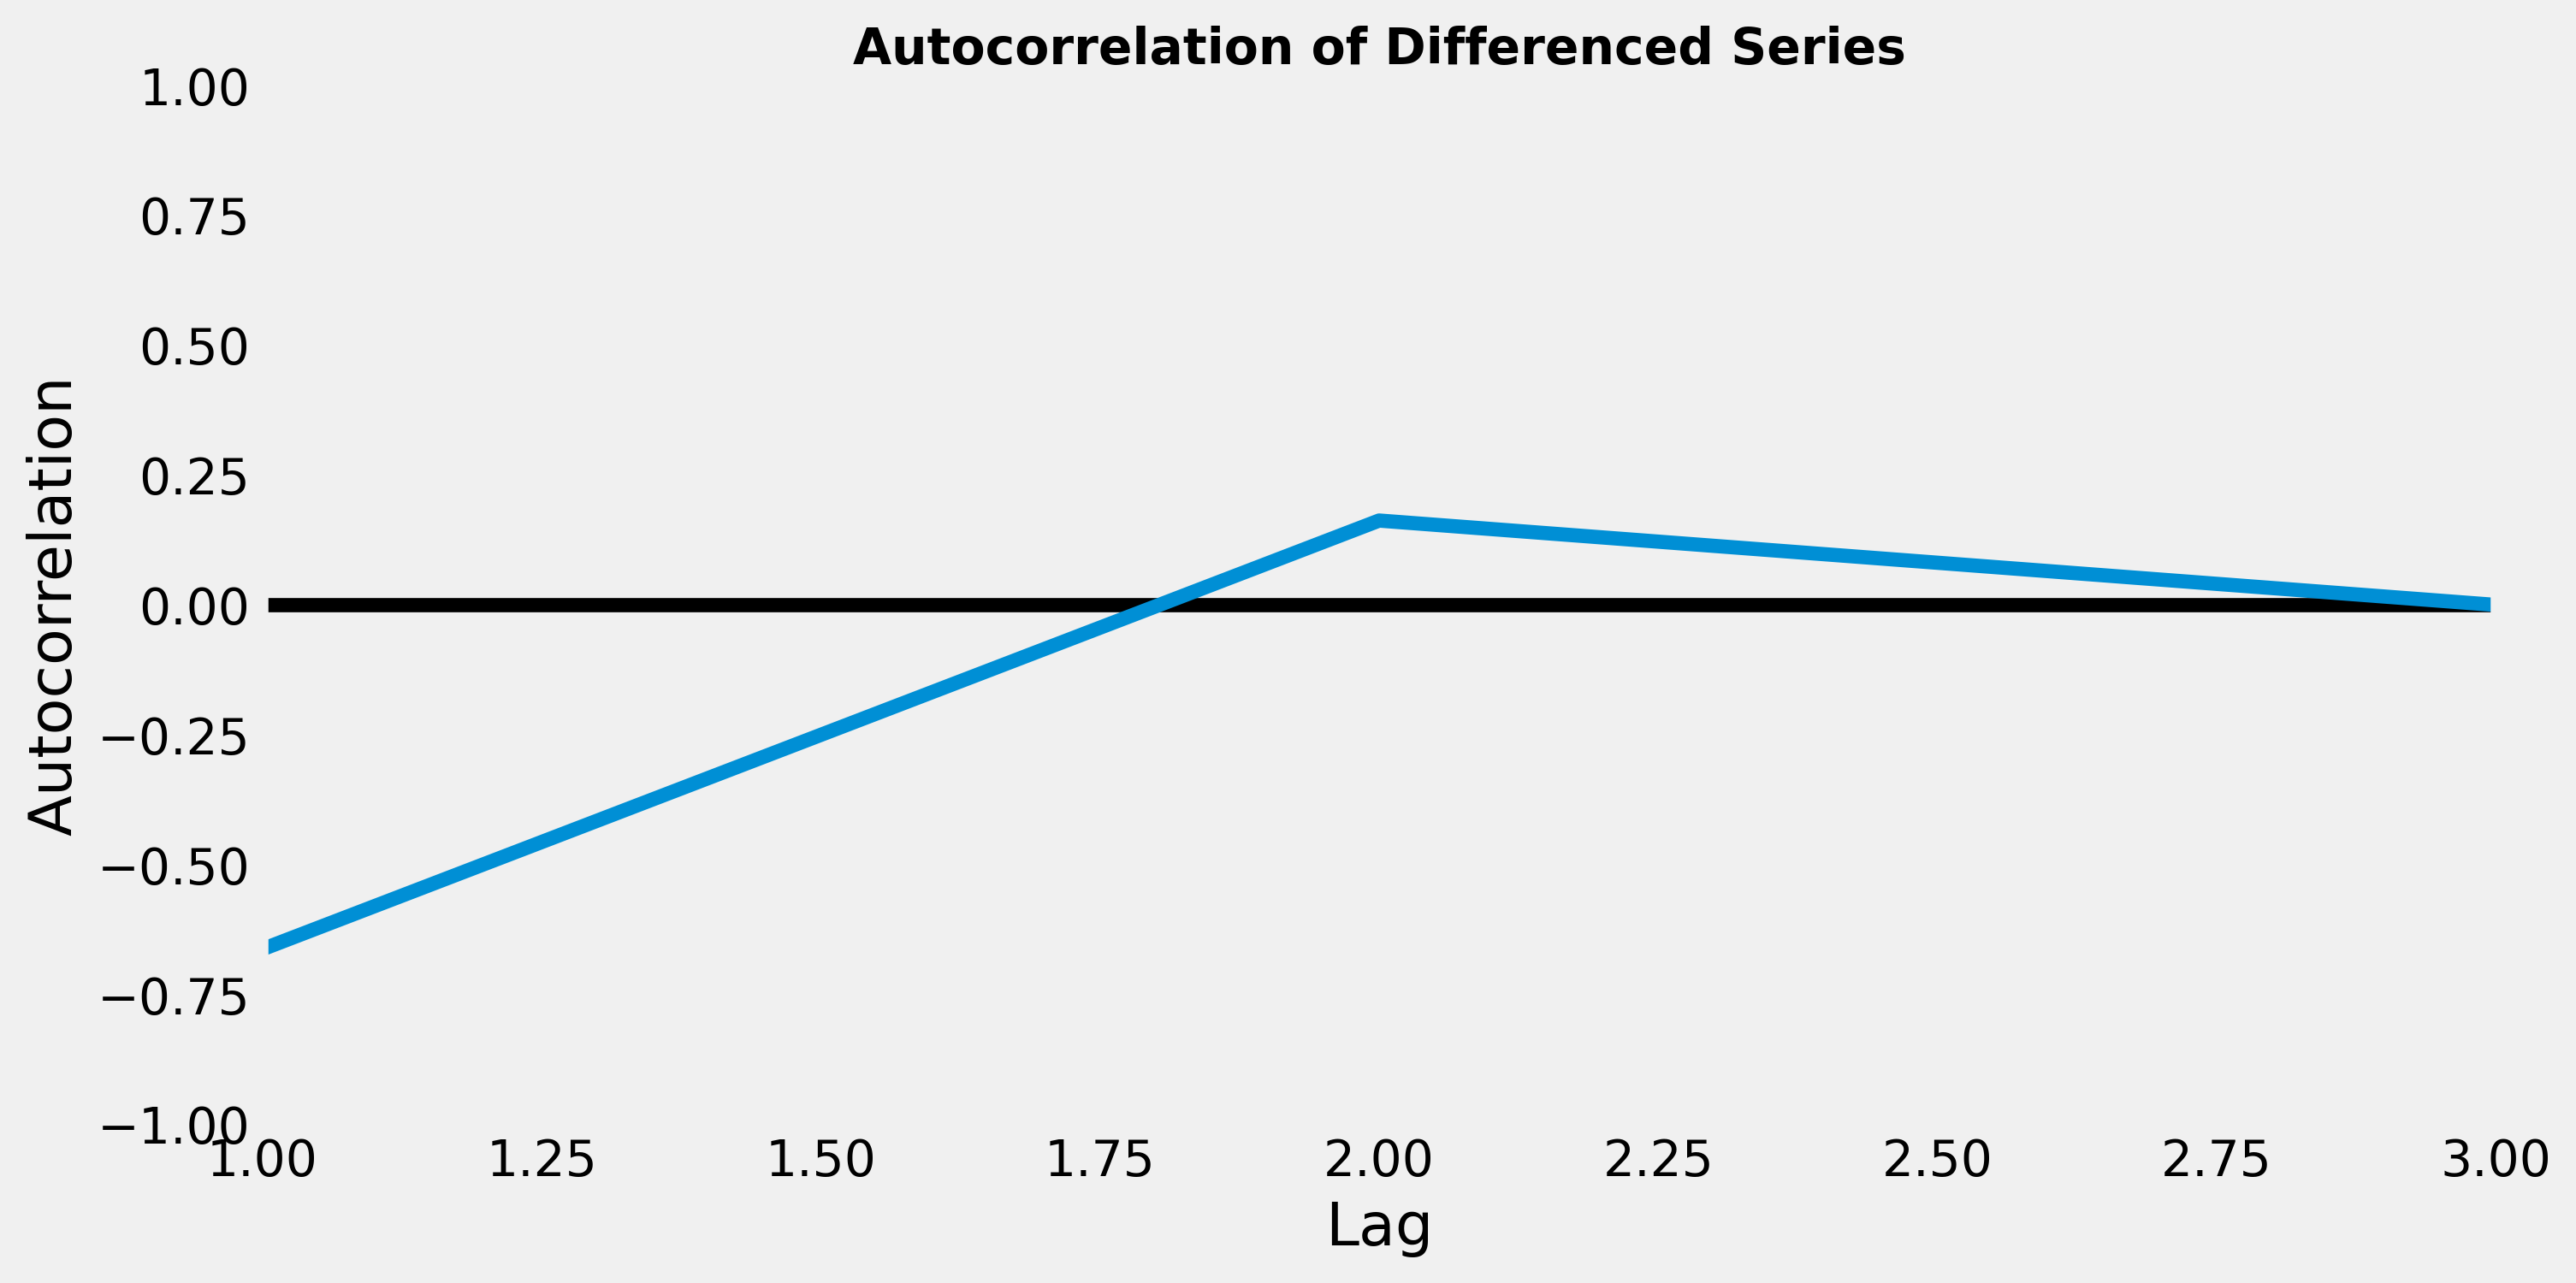

In [54]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5), dpi=300)
autocorrelation_plot(ts_diff)
plt.title("Autocorrelation of Differenced Series", fontsize=14, weight="bold")
plt.show()

**Insights:**

The autocorrelation plot is shown for the differenced CWUR series. However, because the dataset only spans four years (2012–2015), the number of observations is very limited. This means that the autocorrelation does not reveal meaningful lag structures for model identification. In practice, with a longer dataset, autocorrelation would help determine ARIMA model parameters.

## Final Summary

In this task, a time series dataset from the CWUR (2012–2015) was successfully sourced, prepared, and analyzed.

Key findings are as follows:

- Visualization showed fluctuations in average university scores over the short period.

- Decomposition was attempted, but due to the very short length of the dataset, the components were not meaningful.

- The Augmented Dickey-Fuller (ADF) test could not be executed effectively because of insufficient data points.

- Differencing was applied, which stabilized the mean and variance, illustrating the concept of stationarization.

This demonstrates the process of time series analysis, even though the CWUR dataset is too short to draw strong statistical conclusions.